# Mocks

A mock (somtimes called a *fake* or *stub*) is a component that simulates the behavior of a production component sufficiently for tests to be performed on other components that utilize the mocked component.

For this lesson, we will use some examples from the standard library `mock` subpackage of `unittest` and others from the `monkeypatch` fixture in `pytest`.  Other mocking libraries exist, including the plugin `pytest-mock` that wraps `unittest.mock` but provides a more `pytest` style of API.

There are several reasons you might wish to mock a component:

* The real implementation of the mocked component does not exist yet
* The mocked component utilizes resources that are not available when tests are performed
* The real component is slow or uses many resources, but may be faked more cheaply
* The real implementation cannot behave deterministically for testing

Mocks and fixtures are related in that providing a mock **as** a fixture is a common approach.  But sometimes mocks are used in other ways as well.

## Sharing fractals

Continuing to develop our Fractal library, we would like to add the capability for saving generated fractals along with metadata, loading those archives, and downloading archives published by other users of the library.  

Each fractal might take a while to generate and we would like to share the interesting ones we encounter. Of course, we would like to test that we have implemented this behavior correctly as well.   

In [1]:
import sys
import numpy as np
sys.path.append('Fractal')
from fractal.sierpiński import gasket
from fractal.mandelbrot import mandelbrot
from fractal.visualize import make_canvas, visualize
from utility.exchange import make_archive

For example, here is an archive we might create.  We mark an archive by the time is was created, a unique identifier, and a hash of the content of the canvas.

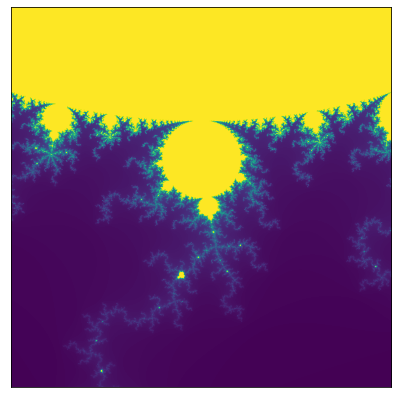

In [2]:
fractal = make_canvas(mandelbrot, -1.0, 0.28, 0.15, 800)
visualize(fractal)

In [3]:
archive = make_archive(fractal, "Mandelbrot centered at -1.0+0.28j")
print(archive)

Description: Mandelbrot centered at -1.0+0.28j
Timestamp:   2020-11-07T14:04:34.170903
UUID:        7a212410-991f-422a-95f7-7fe0e350a21a
Size:        (800, 800)
Fingerprint: fe5f6dc90f49b0b690fe85fc9ebae58b25c96f53


There are certain requirements for the archive format.  Specifically, saved fractal canvases must be 2-dimensional and square, according to our specification.

In [4]:
try:
    make_archive(np.ones([10, 10, 10]))
except ValueError as err:
    print(err)

Canvas must be 2-D and square, not (10, 10, 10)


In [5]:
try:
    make_archive(np.zeros([1000, 2000]))
except ValueError as err:
    print(str(err))

Canvas must be 2-D and square, not (1000, 2000)


## Testing archives

With what we know about testing, there are already some features we should create unit tests for.

```python
from fractal.sierpiński import gasket
from utility.exchange import make_archive
```
```python
def test_archive_gasket():
    desc = "Test Description"
    archive = make_archive(gasket(pixels=729, N=3), desc)
    assert archive.description == desc
    assert archive.canvas.shape == (729, 729)
    hash_ = '04dbb469a0fa7717be4973dfe725b782980da767'
    assert archive.hash_ == hash_
```

We assume that if the implementation of `gasket()` changes, it should still generate the same canvas for the same arguments, and hence have the same hash.  It is an implementation detail that archives use SHA1 rather than some other hash algorithm; however, were that to change, it might break existing archives, which we would like to know.

In [6]:
!cd Fractal; pytest test/test_archives.py::test_archive_gasket

============================= test session starts ==============================
platform linux -- Python 3.8.2, pytest-6.1.2, py-1.9.0, pluggy-0.13.1
rootdir: /home/dmertz/git/INE/unittest/06-Mocks/Fractal
plugins: xdist-2.1.0, forked-1.2.0
collected 1 item                                                               

test/test_archives.py .                                                  [100%]

============================== 1 passed in 1.18s ===============================


Moreover, we can test that the `make_archive()` function raises the expected exception when wrong array shapes are used. It may be too specific to test for a specific exception message, but we can if we wish.

```python
def test_non_square():
    with pytest.raises(ValueError) as err:
        make_archive(np.zeros([100, 200]))
    mess = "Canvas must be 2-D and square, not (100, 200)"
    assert str(err.value) == mess
    
def test_non_2d():
    with pytest.raises(ValueError):
        make_archive(np.ones([30, 30, 30]))
```

In [7]:
!cd Fractal; pytest -v test/test_archives.py

============================= test session starts ==============================
platform linux -- Python 3.8.2, pytest-6.1.2, py-1.9.0, pluggy-0.13.1 -- /home/dmertz/miniconda3/envs/INE/bin/python
cachedir: .pytest_cache
rootdir: /home/dmertz/git/INE/unittest/06-Mocks/Fractal
plugins: xdist-2.1.0, forked-1.2.0
collected 5 items                                                              

test/test_archives.py::test_archive_gasket PASSED                        [ 20%]
test/test_archives.py::test_non_square PASSED                            [ 40%]
test/test_archives.py::test_non_2d PASSED                                [ 60%]
test/test_archives.py::test_archive_timestamp PASSED                     [ 80%]
test/test_archives.py::test_archive_uuid PASSED                          [100%]

============================== 5 passed in 1.78s ===============================


## Mocking transient behavior

A problem that arises is that our archive objects contain a timestamp and a UUID that are each different every time we create an archive.  This is desired behavior since we would like to mark when they are created, and also to distinguish between different users generating of the same canvas.

Most probably two such users would not create theirs at an identical microsecond, but the UUID is globally unique (generating 103 trillion UUIDs creates a one in a billion chance of collision).

By using mocks we can override these generated values to ones we can easily test.  

We can mock within a particular test, but generally it is more flexible to mock within a fixture.  If we mock within one test, we can use the `pytest` built-in fixture `monkeypatch`:

```python
from utility import exchange

@pytest.fixture(scope='session')
def sample_gasket():
    return gasket(pixels=729, N=2)

def test_archive_uuid(monkeypatch, sample_gasket):
    monkeypatch.setattr(exchange, "uuid4", lambda: "Generic-ID")
    archive = make_archive(sample_gasket)
    assert archive.uuid == "Generic-ID"
```

We have perhaps broken our abstraction by looking inside the implementation to determine that `make_archive()` uses `uuid4()` rather than another function for UUIDs (the module `uuid` itself has several, as the number suggests). This is a general pitfall of mocking; it exposes a possible brittleness in tests.

In [8]:
!cd Fractal; pytest -v test/test_archives.py::test_archive_uuid

============================= test session starts ==============================
platform linux -- Python 3.8.2, pytest-6.1.2, py-1.9.0, pluggy-0.13.1 -- /home/dmertz/miniconda3/envs/INE/bin/python
cachedir: .pytest_cache
rootdir: /home/dmertz/git/INE/unittest/06-Mocks/Fractal
plugins: xdist-2.1.0, forked-1.2.0
collected 1 item                                                               

test/test_archives.py::test_archive_uuid PASSED                          [100%]

============================== 1 passed in 0.91s ===============================


Using a fixture rather than patching in the body of a test is generally more flexible.


```python
@pytest.fixture
def fixed_timestamp(monkeypatch):
    class Fixed_datetime(datetime.datetime):
        @classmethod
        def now(cls):
            return datetime.datetime(2020, 1, 1)
    monkeypatch.setattr(exchange, 'datetime', Fixed_datetime)
```
```python
def test_archive_timestamp(fixed_timestamp, sample_gasket):
    archive = make_archive(sample_gasket)
    assert archive.timestamp == '2020-01-01T00:00:00'
```

In [9]:
!cd Fractal; pytest -v test/test_archives.py::test_archive_timestamp

============================= test session starts ==============================
platform linux -- Python 3.8.2, pytest-6.1.2, py-1.9.0, pluggy-0.13.1 -- /home/dmertz/miniconda3/envs/INE/bin/python
cachedir: .pytest_cache
rootdir: /home/dmertz/git/INE/unittest/06-Mocks/Fractal
plugins: xdist-2.1.0, forked-1.2.0
collected 1 item                                                               

test/test_archives.py::test_archive_timestamp PASSED                     [100%]

============================== 1 passed in 0.86s ===============================


## Mocking network communication

A frequent reason to create a mock is because some external resource might not be available during a test. The number servers discussed in the prior lesson operate in threads, but in concept their API could equally communicate with remote servers.

If we did not with to put load on those servers, or if they simply might not exist when tests are run, we can use mocks to simulate their responses.  Sometimes this might also substitute one URI that will always be available during testing for other URIs that the application otherwise accesses.

As an example, we can utilize API calls of a number server, but substitute local versions for those that would otherwise communicate with an external resource.

```python
def test_server_API(monkeypatch):
    server = make_server()
    monkeypatch.setattr(server, 'command', lambda cmd: None)
    monkeypatch.setattr(server, 'get', lambda n: list(range(n)))
    server.command('START PRIMES')
    nums = server.get(1000)
    # Loosely ascending order
    assert max(nums[:100]) < max(nums[450:550]) < max(nums[-100:])
    # This API internally calls `self.get()` on a server
    assert server.get_one() == 0
```

In [10]:
!cd Fractal; pytest -v test/test_numbers.py::test_server_API

============================= test session starts ==============================
platform linux -- Python 3.8.2, pytest-6.1.2, py-1.9.0, pluggy-0.13.1 -- /home/dmertz/miniconda3/envs/INE/bin/python
cachedir: .pytest_cache
rootdir: /home/dmertz/git/INE/unittest/06-Mocks/Fractal
plugins: xdist-2.1.0, forked-1.2.0
collected 1 item                                                               

test/test_numbers.py::test_server_API PASSED                             [100%]

============================== 1 passed in 0.18s ===============================


## Stubbing rather than mocking

The concepts of a stub and a mock are closely related without any sharp distinction.  But as much as they point in different directions, a stub suggests a very simple implementation of the functionality needed for testing.  The full implementation may not even exist yet, but testing its general behavior as utilized by other functions is still useful.

As an alternative approach to the API test of numeric servers, we could implement a complete but simple class sufficient to conduct the particular tests.

```python
def test_server_API2():
    class StubServer:
        def command(self, cmd): pass
        def get(self, n=1):
            return list(range(n))
        def get_one(self):
            return self.get()[0]
```
```python
    server = StubServer()
    server.command('START PRIMES')
    nums = server.get(1000)
    assert len(nums) == 1000
    assert max(nums[:100]) < max(nums[450:550]) < max(nums[-100:])
    assert server.get_one() == 0
```

In [11]:
!cd Fractal; pytest -v test/test_numbers.py::test_server_API2

============================= test session starts ==============================
platform linux -- Python 3.8.2, pytest-6.1.2, py-1.9.0, pluggy-0.13.1 -- /home/dmertz/miniconda3/envs/INE/bin/python
cachedir: .pytest_cache
rootdir: /home/dmertz/git/INE/unittest/06-Mocks/Fractal
plugins: xdist-2.1.0, forked-1.2.0
collected 1 item                                                               

test/test_numbers.py::test_server_API2 PASSED                            [100%]

============================== 1 passed in 0.21s ===============================


Here the stub class was simply written inline in the test, but in development, more likely stubs will live in a separate namespace to allow swapping between full implementations and stubs.  E.g.:

```python
# from server.number_server import make_server  # <- not ready
from server.stubs import make_server  # use for tests
```

You might parameterize tests try both stub and real component.  Or use some configuration, switch or environment variable to choose which to use in a specific test.

## Magic mocks

The `monkeypatch` fixture, or `unitttest.mock.patch` can generally substitute a test version of a method, class, or function for the purpose of testing.  However, the class `unittest.mock.MagicMock` adds some enhanced abilities as well.

```python
def test_prime_jumps():
    expected = iter([1, 2, 5, 19, 103, 733, 6691, 76831, 1081429])
    server = make_server().command('START PRIMES')
    server.get = MagicMock(wraps=server.get)
    n = 1
    while n < 1_000_000:
        nums = server.get(n)
        n = nums[-1]
        server.get.assert_called_with(next(expected))
    server.command('STOP')
```

In [12]:
!cd Fractal; pytest -v test/test_numbers.py::test_prime_jumps

============================= test session starts ==============================
platform linux -- Python 3.8.2, pytest-6.1.2, py-1.9.0, pluggy-0.13.1 -- /home/dmertz/miniconda3/envs/INE/bin/python
cachedir: .pytest_cache
rootdir: /home/dmertz/git/INE/unittest/06-Mocks/Fractal
plugins: xdist-2.1.0, forked-1.2.0
collected 1 item                                                               

test/test_numbers.py::test_prime_jumps PASSED                            [100%]

============================== 1 passed in 1.06s ===============================


## Summary

Mocking or stubbing is a useful tool that enables test-driven development.  My allowing some components or capabilities to be represented by simplified version, or versions that do not require particular resources, the range of tests that can be expressed is increased.

We can mock the behavior of one particular component to provide something suitably similar to what the fleshed out version needs to do that a test of related behavior becomes possible.  By using a mock, we do not rely on that completed and available version of the component during testing.